# 0.0 Import all the modules

In [1]:
import os
import csv
import numpy as np                  # For doing math
import matplotlib.pyplot as plt     # For plotting
import matplotlib.dates as mdates   # For formatting dates when plotting
import matplotlib.colors as colors  # For truncating colorbars
import matplotlib.units as munits
import matplotlib.style as style
import xarray as xr                 # For dealing with netCDF data
import pandas as pd                 # A quick way to deal with time stamps
import netCDF4 as nc                # Another way to deal with netCDF data
import glob
import metpy.calc as mpcalc
import datetime
import scipy.interpolate
import scipy.signal as sig
import scipy.stats as stats
import sys
import scipy.io as sio
from netCDF4 import Dataset
from scipy.optimize import curve_fit

from matplotlib import colors as mcolors
from metpy.plots import Hodograph, SkewT
from metpy.cbook import get_test_data
from metpy.units import units
from scipy.signal import savgol_filter
from scipy.stats import binned_statistic
from matplotlib.gridspec import GridSpec
from numpy.random import seed
from numpy.random import rand
from datetime import datetime

import cartopy.crs as ccrs          # For plotting maps
import cartopy.feature as cfeature  # For plotting maps
import cartopy.io.shapereader as shpreader

import warnings
warnings.filterwarnings('ignore')
print('Done importing modules now')

Done importing modules now


This notebook assumes that your data is located in WRF_DIRECTORY. If you used a different directory structure, you will need to modify it.

In [4]:
WRF_DIRECTORY = '/projects/jiko1138/ATOC_3030/'
DIR_1 = 'Geogrid/Geogrid_Ida'

### 1.0 Make the terrain map of the domain from the geo_em files

In [5]:
DIR_1_d01 = xr.open_dataset(WRF_DIRECTORY + DIR_1 + "/geo_em.d01.nc")
DIR_1_d02 = xr.open_dataset(WRF_DIRECTORY + DIR_1 + "/geo_em.d02.nc")

In [6]:
# Figure out the ref_lat and ref_lon we requested
# (Note this is mixing Datasets and xarray functions...)
ncfile = WRF_DIRECTORY+DIR_1+"/geo_em.d01.nc"
nc_fid = Dataset(ncfile, 'r')  # Dataset is the class behavior to open the file
                             # and create an instance of the ncCDF4 class

desired_lon = nc_fid.getncattr('CEN_LON')
desired_lat = nc_fid.getncattr('CEN_LAT')

print(desired_lon)
print(desired_lat)

# desired_lon = -91.7107986
# desired_lat = 41.8846886

-90.44233
29.348877


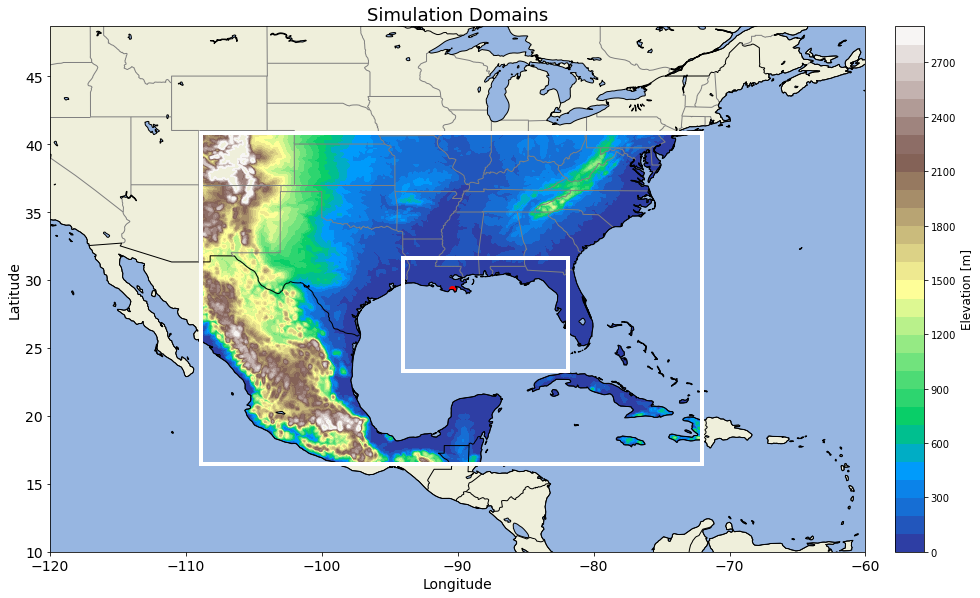

In [10]:
### Useful data and parameters for plotting

c_levels = np.arange(0, 3000, 100)

## Pull lat/lon from the dataset
lats1 = DIR_1_d01['XLAT_M'].isel(Time=0) 
longs1 = DIR_1_d01['XLONG_M'].isel(Time=0)
hgt1 = DIR_1_d01['HGT_M'].isel(Time=0)

lats2 = DIR_1_d02['XLAT_M'].isel(Time=0)
longs2 = DIR_1_d02['XLONG_M'].isel(Time=0)
hgt2 = DIR_1_d02['HGT_M'].isel(Time=0)

## Extract min/max values if you chose to bound the size of the map
min_lat1 = lats1.values.min()
max_lat1 = lats1.values.max()
min_lon1 = longs1.values.min()
max_lon1 = longs1.values.max()
MAP_BOUNDS1 = [min_lon1, max_lon1, min_lat1, max_lat1]

min_lat2 = lats2.values.min()
max_lat2 = lats2.values.max()
min_lon2 = longs2.values.min()
max_lon2 = longs2.values.max()
MAP_BOUNDS2 = [min_lon2, max_lon2, min_lat2, max_lat2]

# Create figure and axes objects
fig = plt.figure(figsize=(18,10))
fig.patch.set_facecolor('white')
ax = plt.axes(projection=ccrs.PlateCarree())

# Bound and fill in nice lines

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

ax.set_extent([-120,-60,10,45])

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.LAKES, edgecolor='k', zorder=1)
ax.add_feature(cfeature.OCEAN, edgecolor='k', zorder=1)
ax.coastlines('50m', linewidth=0.5)

# Draw bounding box for inner domain
ax.plot((min_lon1, min_lon1), (min_lat1, max_lat1), lw=4, color='w')
ax.plot((max_lon1, max_lon1), (min_lat1, max_lat1), lw=4, color='w')
ax.plot((min_lon1, max_lon1), (min_lat1, min_lat1), lw=4, color='w')
ax.plot((min_lon1, max_lon1), (max_lat1, max_lat1), lw=4, color='w')

ax.plot((min_lon2, min_lon2), (min_lat2, max_lat2), lw=4, color='w')
ax.plot((max_lon2, max_lon2), (min_lat2, max_lat2), lw=4, color='w')
ax.plot((min_lon2, max_lon2), (min_lat2, min_lat2), lw=4, color='w')
ax.plot((min_lon2, max_lon2), (max_lat2, max_lat2), lw=4, color='w')

im=ax.contourf(DIR_1_d01['XLONG_M'].values[0, :, :],
    DIR_1_d01['XLAT_M'].values[0, :, :],
    DIR_1_d01['HGT_M'].values[0, :, :], c_levels,
    cmap=plt.cm.terrain, projection=ccrs.PlateCarree())

#### Projection is messed up here - figure out how to fix this!

# Add important info to the plot
ax.set_title("Simulation Domains", fontsize=18)
ax.xaxis.set_visible(True)    # Set xaxis visible because cartopy hides it by default
ax.yaxis.set_visible(True)
ax.tick_params(labelsize=14)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)

ax.scatter([desired_lon], [desired_lat], color='r') # Dot for location of BAO

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.8, 0.15, 0.022, 0.73])                                             
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Elevation [m]", fontsize=12)

# Adjust figure height so the xlabel isn't cut off when saved
plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig("domain.png")
plt.savefig("domain.pdf")

plt.show()